# Numerical solution
__Kozhemyak Vitaly__

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import datetime as dt

In [6]:
sns.set_theme()

## Task 1 

In [2]:
def move1(p, q):
    # (rock, csissors, paper) <-> (1, 2, 3)
    choice = np.random.choice(
        np.arange(3) + 1, 
        p=[p, q, 1 - p - q]
    )
    
    return choice

def move2(distr=()):
    if not distr:
        eta = np.random.rand(2)
    else:
        eta = np.random.beta(distr, 2)
    choice = np.random.choice(
        np.arange(3) + 1, 
        p=[min(eta), max(eta) - min(eta), 1 - max(eta)]
    )
    
    return choice

def game(n, distr=()):
    n = 1000
    prob = np.zeros((4, 4))
    for i, p in enumerate([0, 1/3, 2/3, 1]):
        for j, q in enumerate([0, 1/3, 2/3, 1]):
            if p + q > 1:
                prob[i, j] = np.nan
                continue

            count = 0
            for _ in range(n):
                player1 = move1(p, q)
                player2 = move2(distr)
                if (player1, player2) == (1, 2) \
                    or (player1, player2) == (2, 3) \
                    or (player1, player2) == (3, 1):
                    count += 1

            prob[i, j] = (count / n)
    
    return prob

In [3]:
def plot_heatmap(data, ax):
    sns.heatmap(
        data, 
        annot=True,
        vmax=1,
        vmin=0,
        linewidths=.5,
        xticklabels=np.round([0, 1/3, 2/3, 1], 2),
        yticklabels=np.round([0, 1/3, 2/3, 1], 2),
        ax=ax
    )

Text(767.7272727272725, 0.5, 'q')

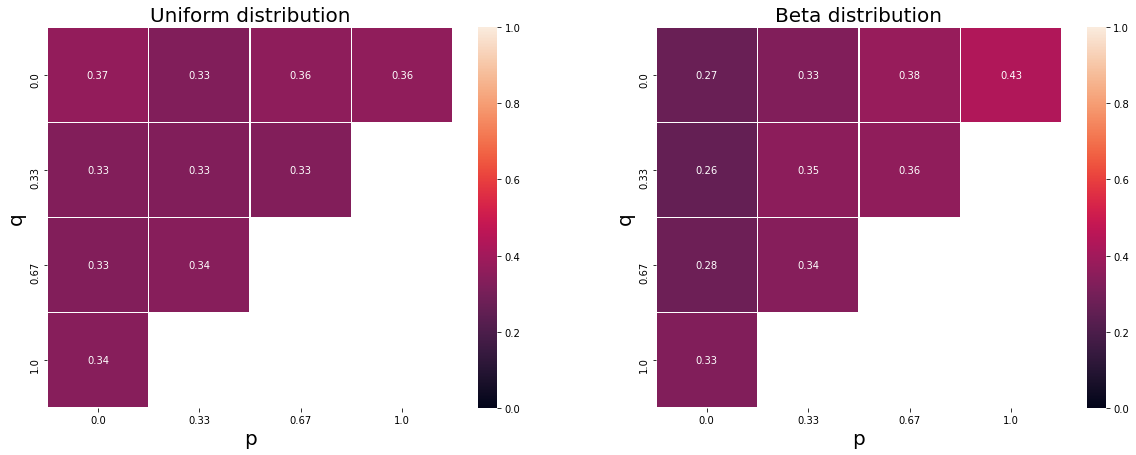

In [4]:
n = 100
uniform_data = game(n, distr=())
beta_data = game(n, distr=(1, 2))

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plot_heatmap(uniform_data, ax=ax[0])
plot_heatmap(beta_data, ax=ax[1])
ax[0].set_title("Uniform distribution", fontsize=20)
ax[0].set_xlabel("p", fontsize=20)
ax[0].set_ylabel("q", fontsize=20)
ax[1].set_title("Beta distribution", fontsize=20)
ax[1].set_xlabel("p", fontsize=20)
ax[1].set_ylabel("q", fontsize=20)
# fig.savefig("Images/Task1.png", format="png", dpi=300)

## Task 2

In [102]:
alpha = 0.95
lam = 2
n = 100000
m = 1000
size = (m, n)

In [98]:
def exp_alpha_quantile(alpha, lam):
    return - np.log(1 - alpha) / lam

# right side
x_alpha = exp_alpha_quantile(alpha, lam)
sigma = np.sqrt(alpha * (1 - alpha) / (lam * np.exp(-lam * x_alpha))**2)
right_side = np.random.normal(0, sigma, m)

Empirical variance = 4.73, Theoretical variance = 4.75


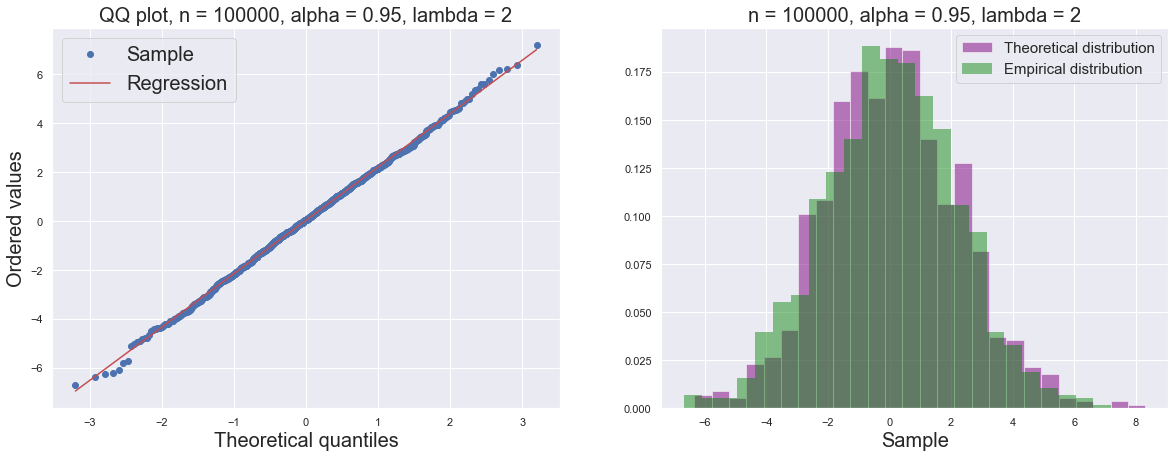

In [103]:
# left side
X = -np.log(1 - np.sort(np.random.rand(size[0], size[1]))[:, int(n * alpha)]) / lam


x_alpha = exp_alpha_quantile(alpha, lam)
left_side = np.sqrt(n) * (X - x_alpha)


# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
_ = scipy.stats.probplot(left_side, dist="norm", plot=ax[0])
ax[0].set_xlabel("Theoretical quantiles", fontsize=20)
ax[0].set_ylabel("Ordered values", fontsize=20)
ax[0].set_title("QQ plot, n = {}, alpha = {}, lambda = {}".format(n, alpha, lam), fontsize=20)
ax[0].legend(("Sample", "Regression"), fontsize=20)

_ = ax[1].hist(
    right_side, 
    bins="auto", 
    density=True, 
    alpha=0.5, 
    color="purple",
    edgecolor=None,
    linewidth=1,
    label="Theoretical distribution"
)

_ = ax[1].hist(
    left_side, 
    bins="auto", 
    density=True, 
    alpha=0.45, 
    color="green", 
    edgecolor=None,
    linewidth=0,
    label="Empirical distribution"
)
ax[1].legend(fontsize=15)
ax[1].set_xlabel("Sample", fontsize=20)
ax[1].set_title("n = {}, alpha = {}, lambda = {}".format(n, alpha, lam), fontsize=20)
# fig.savefig("Images/Task2_{}.png".format(n), format="png", dpi=300)
print(
    "Empirical variance = {}, Theoretical variance = {}".format(
        round(left_side.var(), 2), round(sigma**2, 2)
    )
)

## Task 3

In [21]:
from scipy.stats import laplace
from statsmodels.sandbox.regression.gmm import GMM

Text(0, 0.5, 'Method')

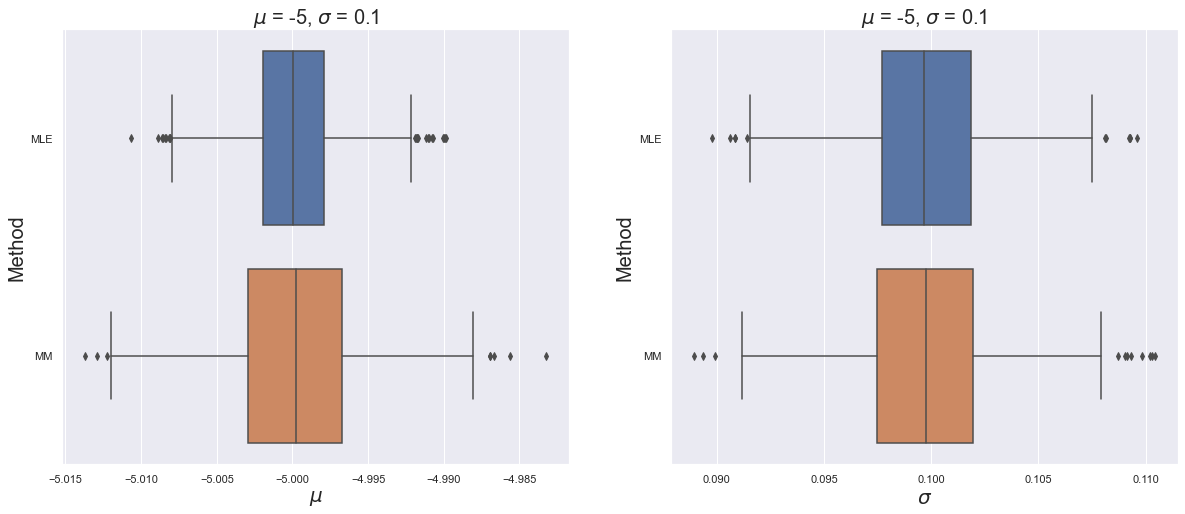

In [22]:
def MLE(mu, sigma, X):
#     mu_list, sigma_list = [], []
#     for i in range(100):
#         mu_hat, sigma_hat = laplace.fit(X[i, :])
#         mu_list.append(mu_hat)
#         sigma_list.append(sigma_hat)

#     data = pd.DataFrame()
#     data["mu"] = mu_list
#     data["sigma"] = sigma_list
#     data["method"] = "MLE"
    data = pd.DataFrame()
    data["mu"] = np.median(X, axis=1)
    data["sigma"] = np.abs(X - np.median(X, axis=1, keepdims=True)).mean(axis=1)
    data["method"] = "MLE"

    return data
    
def MM(mu, sigma, X):
    data = pd.DataFrame()
    data["mu"] = X.mean(axis=1)
    data["sigma"] = np.sqrt(0.5 * (np.mean(X**2, axis=1) - np.mean(X, axis=1)**2))
    data["method"] = "MM"
    
    return data
    
mu, sigma = -5, 0.1
sample_size = (1000, 1000)
X = laplace.rvs(mu, sigma, size=sample_size)

data = MLE(mu, sigma, X)
data = data.append(MM(mu, sigma, X))
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(x=data["mu"], y=data["method"], ax=ax[0])
sns.boxplot(x=data["sigma"], y=data["method"], ax=ax[1])

ax[0].set_title("$\mu$ = {}, $\sigma$ = {}".format(mu, sigma), fontsize=20)
ax[1].set_title("$\mu$ = {}, $\sigma$ = {}".format(mu, sigma), fontsize=20)
ax[0].set_xlabel("$\mu$", fontsize=20)
ax[1].set_xlabel("$\sigma$", fontsize=20)
ax[0].set_ylabel("Method", fontsize=20)
ax[1].set_ylabel("Method", fontsize=20)
# fig.savefig("Images/Task3_1.png", format="png", dpi=300)

## Task 4

In [23]:
# prepare DataFrame
stock_df = pd.read_csv("Data/stock.txt")
stock_df["date"] = stock_df["date"].apply(lambda x: pd.to_datetime(x).date())
stock_df.replace({"MSFT": "Microsoft", "AMZN": "Amazon", "GOOG": "Google", "AAPL": "Apple"}, inplace=True)
stock_df = stock_df.rename(columns={"symbol": "company"})
stock_df.sort_values(["company", "date"], inplace=True)
stock_df.index = stock_df["date"]
stock_df.drop(columns=["date"], inplace=True)
stock_df = stock_df[stock_df["company"] != "Google"]

In [24]:
from scipy.stats import norm

In [25]:
# estimate parameter theta
theta = {}
for company in stock_df["company"].unique():
    series = stock_df[stock_df["company"] == company]["price"]
    shift_series = pd.Series(series).shift(1)
    log_income = np.log(series / shift_series).dropna()
    split = np.linspace(0, len(log_income), 11).astype(int)
    theta[company] = []
    for i, segment in enumerate(split):
        if i != len(split) - 1:
            theta[company].append(np.round(norm.fit(log_income[split[i] : split[i + 1]], floc=0), 2))

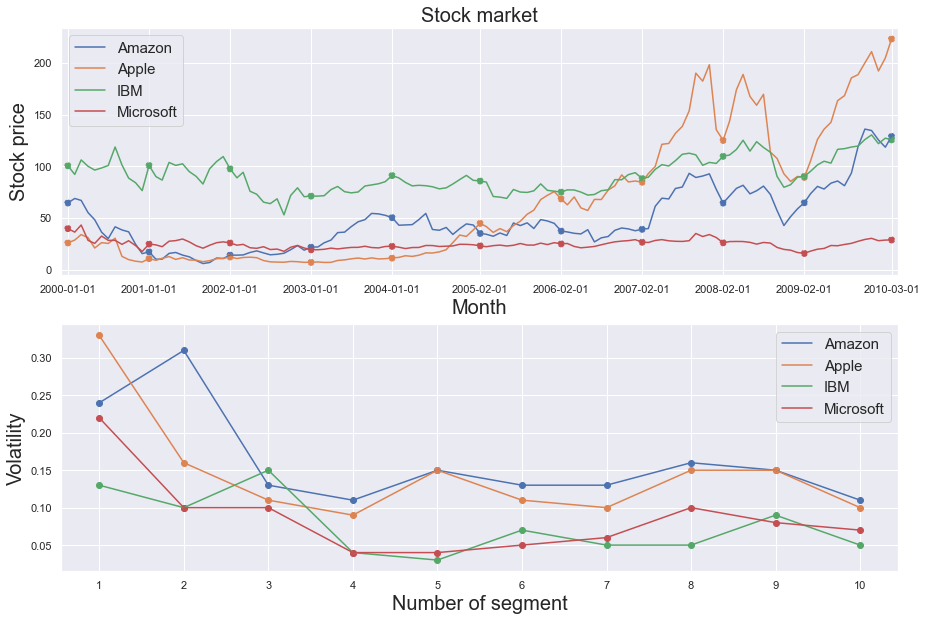

In [29]:
# plot reults
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

for company in stock_df["company"].unique():
    series = stock_df[stock_df["company"] == company]["price"]
    split = np.linspace(0, len(series) - 1, 11).astype(int)
    ax[0].plot(series, label=company)
    ax[0].scatter(series.index[split], series.values[split], ls="--")
    ax[0].set_xticks(series.index[split])
    ax[0].set_xlim((series.index[split].min() - dt.timedelta(30), 
                    series.index[split].max() + dt.timedelta(30)))
    
    
#     ax[1].plot(series.index[split][:-1], [p[1] for p in theta[company]], label=company)
#     ax[1].scatter(series.index[split][:-1], [p[1] for p in theta[company]])
#     ax[1].set_xticks(series.index[split])
#     ax[1].set_xlim((series.index[split].min() - dt.timedelta(30), 
#                     series.index[split].max() + dt.timedelta(30)))
    ax[1].plot(np.arange(1, 11), [p[1] for p in theta[company]], label=company)
    ax[1].scatter(np.arange(1, 11), [p[1] for p in theta[company]])
    ax[1].set_xticks(np.arange(1, 11))


    
ax[0].legend(fontsize=15)
ax[0].set_title("Stock market", fontsize=20)
ax[0].set_xlabel("Month", fontsize=20)
ax[0].set_ylabel("Stock price", fontsize=20)

ax[1].legend(fontsize=15)
ax[1].set_xlabel("Number of segment", fontsize=20)
ax[1].set_ylabel("Volatility", fontsize=20)

# fig.savefig("Images/Task4.png", format="png", dpi=300)